# Hamiltonian simulation with Gray code encoding - statevector simulator

In [15]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [28]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]
from scipy.linalg import eigh
n_qubits=2
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)
# H.matrix
exact_eigenvalue,_=eigh(H.matrix)
print(exact_eigenvalue)

{'IX': -7.813951636042159, 'ZX': 3.5273445861715977, 'XI': -3.913118960624632, 'XZ': 3.913118960624632, 'II': 14.3283547225, 'ZI': -8.4216452775, 'IZ': -1.4216452774999997, 'ZZ': -4.9216452775}
[-2.14398103  6.07151323 17.75169828 35.63418841]


In [17]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XX ['II', 'IX', 'XI', 'XX']
XY ['IY', 'XY']
XZ ['IZ', 'XZ']
YX ['YI', 'YX']
YY ['YY']
YZ ['YZ']
ZX ['ZI', 'ZX']
ZY ['ZY']
ZZ ['ZZ']


In [200]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=20
delta_time=0.01
n_qubits=3

initialization="zeros"
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
exact_eigenvalue,_=eigh(H.matrix)
print(exact_eigenvalue)

backend = 'statevector_simulator'
sv_energies,Ccoefs_sv=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

threshold=1e-2
backend = 'qasm_simulator'
qasm_energies,Ccoefs_qasm=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=2)



  0%|          | 0/20 [00:00<?, ?it/s]

[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


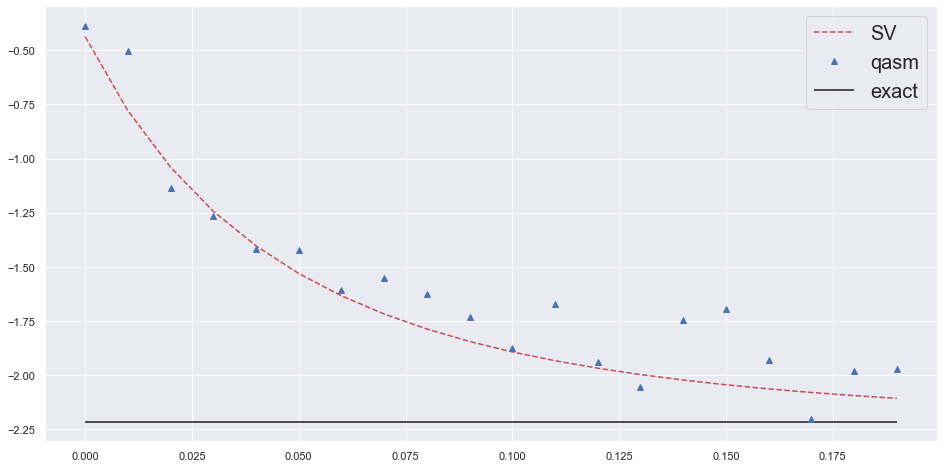

In [201]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="SV")
plt.plot(time,qasm_energies,'b^',label="qasm")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [212]:
def normalization_coefficient(ncoefs,Ccoefs,r):
    nr=ncoefs[r-1]
    Cr=Ccoefs[r-1]
    return nr/np.sqrt(Cr)

def normalization_coefficients(Ccoef):
    ncoefs=np.zeros(len(Ccoef))
    ncoefs[0]=1/np.sqrt(Ccoef[0])
    for r in range(1,len(Ccoef)):
        
#         Cr=Ccoef[r-1]
#         nr=ncoefs[r-1]
        ncoefs[r]=normalization_coefficient(ncoefs,Ccoef,r)
    
    return ncoefs

ncoefs=normalization_coefficients(Ccoefs_sv)
print(ncoefs)

[0.99566257 0.99134396 0.98371098 0.97363315 0.96174749 0.94852753
 0.93432968 0.91942514 0.90402231 0.88828271 0.87233242 0.85627053
 0.84017528 0.82410872 0.80812016 0.7922489  0.77652621 0.76097694
 0.74562079 0.73047324]


In [184]:
# from scipy.linalg import eig
## Construct overlap matrix
lanczos_stride=4
max_krylov_dim=8

ncoefs=normalization_coefficients(Ccoefs_sv)
print(ncoefs)

regularization_factors={}
index_list=[0]
thres=.999
for i in range(2,len(ncoefs),2):
    j=index_list[-1]
    k=int((i+j)/2)
    regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
    print(i,regularization_factor)
    if regularization_factor<thres:
        index_list.append(i)
        regularization_factors[i]=regularization_factor
    
dim=min(len(index_list),max_krylov_dim)

index_list=index_list[-dim:]
print(index_list)

Omatrix=np.asmatrix(np.zeros((dim,dim)))
Hmatrix=np.asmatrix(np.zeros((dim,dim)))

for i in range(dim):
    for j in range(dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Omatrix[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

## Construct H matrix 
for i in range(0,dim):
    for j in range(0,dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Hmatrix[i,j]=Omatrix[i,j]*sv_energies[k]
# print(Hmatrix)


eigs,_=eigh(Hmatrix,Omatrix)
print(eigs)
print("")
print("Num iterations: ",num_iterations)
print("QITE:     ",sv_energies[-1])
print("QLanczos: ",eigs.real[0])
print("Exact:    ",exact_eigenvalue[0])

[0.99566257 0.99134396 0.98371098 0.97363315 0.96174749 0.94852753
 0.93432968 0.91942514 0.90402231 0.88828271 0.87233242 0.85627053
 0.84017528 0.82410872 0.80812016 0.7922489  0.77652621 0.76097694
 0.74562079 0.73047324]
2 0.9966231570385965
4 0.9980168591930022
6 0.9987604191441732
8 0.9991864728046412
10 0.9972955000146124
12 0.9996084491931496
14 0.9986611487548469
16 0.9997899550840248
18 0.9992673907267212
[0, 2, 4, 6, 10, 14]
[-2.21418681  2.63012839  8.39332409 15.91539509 24.92280535 35.66895093]

Num iterations:  20
QITE:      -2.107838690508591
QLanczos:  -2.214186811526883
Exact:     -2.2150378722680117


In [206]:
## Construct overlap matrix and H matrix in Krylov basis
lanczos_stride=2
max_krylov_dim=4

ncoefs=normalization_coefficients(Ccoefs_qasm)
# print(ncoefs)

regularization_factors={}
index_list=[0]
thres=.999
for i in range(2,len(ncoefs),2):
    j=index_list[-1]
    k=int((i+j)/2)
    regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
#     print(i,regularization_factor)
    if regularization_factor<thres:
        index_list.append(i)
        regularization_factors[i]=regularization_factor

# print("stride",lanczos_stride)
# index_list=[]
# for i in range(0,num_iterations,lanczos_stride):
#     index_list.append(i)

dim=min(len(index_list),max_krylov_dim)

index_list=index_list[-dim:]
# index_list=index_list[:dim]
print(index_list)

Omatrix=np.asmatrix(np.zeros((dim,dim)))
Hmatrix=np.asmatrix(np.zeros((dim,dim)))

for i in range(dim):
    for j in range(dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Omatrix[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

Oeigs,Ovecs=eig(Omatrix)
print(Oeigs)
threshold=1e-2
Odiag=np.zeros((dim,dim))
for i in range(dim):
    if abs(Oeigs[i].real)>threshold:
        Odiag[i,i]=Oeigs[i]

print(Omatrix)
Omatrix2=np.dot(Ovecs.transpose(),np.dot(Odiag,Ovecs))
print("")
print(Omatrix2)
print("")
        
## Construct H matrix 
for i in range(0,dim):
    for j in range(0,dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Hmatrix[i,j]=Omatrix2[i,j]*qasm_energies[k]
# print(Hmatrix)


eigs,_=eig(Hmatrix,Omatrix2)
print(eigs)
print("")
print("Num iterations: ",num_iterations)
print("QITE:     ",sv_energies[-1])
print("QLanczos: ",eigs.real[0])
print("Exact:    ",exact_eigenvalue[0])

[8, 10, 14, 18]
[ 3.98797008e+00+0.j -1.71029008e-03+0.j  5.03209498e-03+0.j
  8.70811611e-03+0.j]
[[1.         0.99895997 0.99581305 0.99248112]
 [0.99895997 1.         0.99566683 0.99969906]
 [0.99581305 0.99566683 1.         0.99331296]
 [0.99248112 0.99969906 0.99331296 1.        ]]

[[ 0.99663686 -0.82833069  1.21715012 -0.90204589]
 [-0.82833069  0.68844709 -1.01160498  0.74971369]
 [ 1.21715012 -1.01160498  1.48645358 -1.1016302 ]
 [-0.90204589  0.74971369 -1.1016302   0.81643256]]

[-1.89506039+0.j         inf+0.j         inf+0.j         inf+0.j]

Num iterations:  20
QITE:      -2.107838690508591
QLanczos:  -1.8950603917361801
Exact:     -2.2150378722680117


In [303]:
def Krylov_matrices(krylov_indices,ncoefs,energies,threshold=1e-2):
    dim=len(krylov_indices)
    
    ## Construct overlap matrix
    T=np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            T[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

    ## Elimiate small eigenvalues form overlap matrix
    eigs,evecs=eig(T)
    D=np.zeros((dim,dim))
    for i in range(dim):
        if abs(eigs[i].real)>threshold:
            D[i,i]=Oeigs[i]
            
    T=np.dot(evecs.transpose(),np.dot(D,evecs))  
            
    ## Construct H matrix 
    H=np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            H[i,j]=T[i,j]*energies[k]
            
    return T,H



def run_qlanczos_experiment(H,krylov_dim,delta_time,backend,initialization,max_iterations=100,krylov_threshold=.99999,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
#     print("num qubits",n_qubits)
    n_shots=10000 ## Set to allowed number of shots at IBMQ

    ## Get list of sigmas (all pauli terms with odd number Y gates)
    sigmas=get_sigma_pauli_terms(n_qubits)

    ## Construct b in terms of paulis 
    b_pauli_terms=b_terms(H,sigmas)
    
    ## Construct S in terms of paulis
    S_pauli_terms=S_terms(sigmas)

    ## Get composite set of pauli terms that need to be calculated for QITE 
    pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

    ## Get commuting set 
    commuting_sets=get_commuting_sets(sorted(pauli_set))
    
    ## Zero initialize 
    A_set=[]
    a=np.zeros(len(sigmas))
#     Energies=np.zeros(num_iterations)
#     Ccoefs=np.zeros(num_iterations)
    Energies=[]
    Ccoefs=[]
    ncoefs=[]
    
    ## for each time step, run circuit and compute A for the next time step
    krylov_indices=[0]
    t=0
    while len(krylov_indices)<krylov_dim:
        if t>max_iterations:
            break
        expectation_values={}
        if backend=='statevector_simulator':
            ## Run circuit to get state vector
            psi=run_circuit_statevector(n_qubits,A_set,initialization=None)

            ## Compute expectation value for each pauli term 
            for pauli_id in commuting_sets:        
                for pauli in commuting_sets[pauli_id]: 
                    pauli_mat = get_pauli_matrix(pauli)
                    e_value=np.conj(psi).T @ pauli_mat @ psi
                    expectation_values[pauli]=e_value

        else:
            for pauli_id in commuting_sets:   
                ## Run circuit to get counts 
                meas_results=run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=n_shots,initialization=initialization)

                ## Compute expectation value for each pauli term 
                for pauli in commuting_sets[pauli_id]: 
                    expectation_values[pauli]=compute_expectation_value(pauli,meas_results)    


        ## Compute energy
        H_pauli=H.pauli_coeffs
        energy=0.0
        for key in H_pauli:
            energy+=H_pauli[key]*expectation_values[key]

        Energies.append(energy.real)

        ## compute normalization coef C=1-2*E*delta_times
        Ccoef=1-2*delta_time*Energies[t]
        Ccoefs.append(Ccoef)
        
        ## Compute A
        A_set.append(A_pauli_operator(delta_time,sigmas,S_pauli_terms,b_pauli_terms,expectation_values,Ccoef,A_threshold))

        if isinstance(cstep,int):
            if t%cstep==0:
                identity_string="I"*n_qubits
                A_combine=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])
                for A in A_set:
                    A_combine+=A
                A_set=[A_combine]
         
        ### Compute normalization factor 
        if t==0:
            ncoefs.append(1.0)
        else:
            ncoefs.append(normalization_coefficient(ncoefs,Ccoefs,t))
            
            ## If even time step, check overlap
            if t%2==0:        
                i=t
                j=krylov_indices[-1]
                k=int((i+j)/2)
                regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
                if regularization_factor<krylov_threshold:
                    krylov_indices.append(i)
        
        ### increment t
        t+=1
    print("iterations :",t)
    print(krylov_indices)
    
    ## Solve generalized eigenproblem 
    ## Construct krylove matries 
    T_krylov,H_krylov=Krylov_matrices(krylov_indices,ncoefs,Energies,threshold=1e-1)
    ## Solve generalized eigenproblem
    eigs,vecs=eig(H_krylov,T_krylov)
    idx = eigs.argsort()[0]
    print(eigs.real)
    print(eigs.real[idx])
    return Energies,Ccoefs



In [308]:
# n_qubits=4
# krylov_dim=7
# kthreshold=.999
# max_itr=100

delta_time=0.01

initialization="zeros"
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
exact_eigenvalue,_=eigh(H.matrix)
print(exact_eigenvalue)

backend = 'statevector_simulator'
n_qubits=5
# krylov_dim=7
# kthreshold=.999
krylov_dim=8
kthreshold=.9985
max_itr=100
QLenergies,QLcoefs=run_qlanczos_experiment(H,krylov_dim,delta_time,backend,initialization,max_iterations=max_itr,krylov_threshold=kthreshold,A_threshold=1e-10,cstep=1)
print(QLenergies[-1])


[ -2.22122453   0.42948358   1.65222837   3.56849325   6.10758483
   9.21556747  12.8522503   17.00001551  21.66870631  26.88632436
  32.68372394  39.08715811  46.11949765  53.80366834  62.16498465
  71.23241086  81.03945488  91.62511049 103.03503636 115.32310217
 128.5534621  142.80339685 158.1673077  174.76249911 192.73785478
 212.28743465 233.6729772  257.26384175 283.61488098 313.63986779
 349.08651524 394.44980383]
iterations : 47
[0, 2, 4, 8, 12, 18, 28, 46]
[-2.18265097 -2.21677681         inf         inf         inf         inf
         inf         inf]
-2.2167768079628654
-2.193122334446787
